<a href="https://colab.research.google.com/github/TheOctoMizer/AAI-510-Project/blob/main/LSTM_RandomForest_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ====================
# 1. Imports
# ====================
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
# ====================
# 2. Load Data
# ====================
df = pd.read_csv('multilingual_sentiment_195k.csv')

In [6]:
# ====================
# 3. Clean Text
# ====================
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text'] = df['text'].fillna('').apply(clean_text)

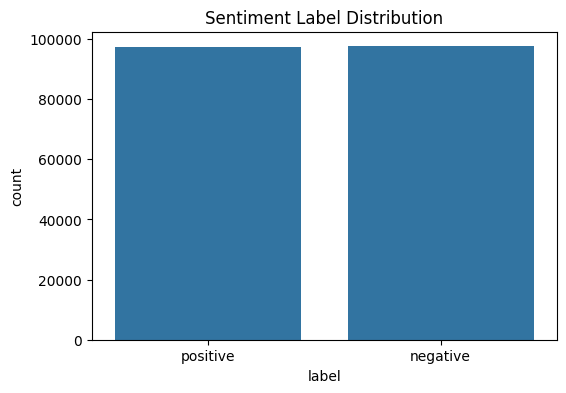

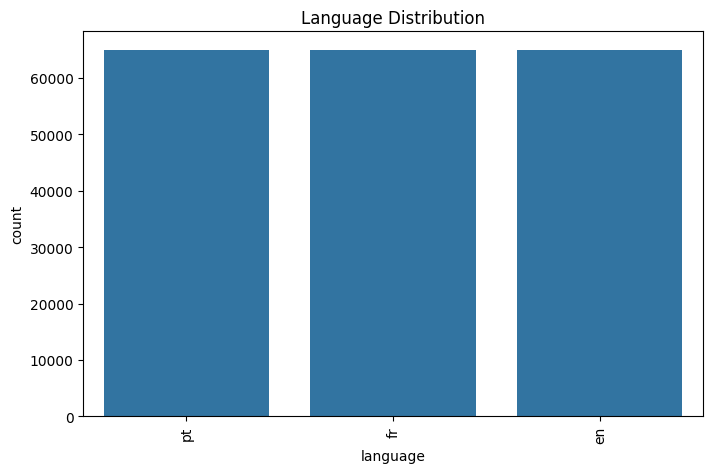

In [7]:
# ====================
# 4. EDA
# ====================
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Sentiment Label Distribution')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='language', data=df, order=df['language'].value_counts().index)
plt.title('Language Distribution')
plt.xticks(rotation=90)
plt.show()

In [8]:
# ====================
# 5. Encode labels
# ====================
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])


In [9]:
# ====================
# 6. Train-Test Split
# ====================
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [10]:
# ====================
# 7. Vectorization
# ====================
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [11]:
# ====================
# 8. Logistic Regression
# ====================
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
print('Logistic Regression Report:')
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     19516
           1       0.82      0.84      0.83     19484

    accuracy                           0.83     39000
   macro avg       0.83      0.83      0.83     39000
weighted avg       0.83      0.83      0.83     39000



In [12]:
# ====================
# 9. Random Forest
# ====================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)
print('Random Forest Report:')
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82     19516
           1       0.82      0.81      0.81     19484

    accuracy                           0.82     39000
   macro avg       0.82      0.82      0.82     39000
weighted avg       0.82      0.82      0.82     39000



In [13]:
# ====================
# 10. LSTM Model Preparation
# ====================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)


In [14]:
# ====================
# 11. LSTM Model
# ====================
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 423s 343ms/step - accuracy: 0.7539 - loss: 0.4729 - val_accuracy: 0.8375 - val_loss: 0.3339
Epoch 2/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 411s 337ms/step - accuracy: 0.8546 - loss: 0.3092 - val_accuracy: 0.8402 - val_loss: 0.3378
Epoch 3/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 443s 338ms/step - accuracy: 0.8679 - loss: 0.2805 - val_accuracy: 0.8424 - val_loss: 0.3397
Epoch 4/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 420s 345ms/step - accuracy: 0.8769 - loss: 0.2622 - val_accuracy: 0.8404 - val_loss: 0.3463
Epoch 5/5
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 410s 336ms/step - accuracy: 0.8894 - loss: 0.2397 - val_accuracy: 0.8396 - val_loss: 0.3685


In [15]:
# ====================
# 12. LSTM Evaluation
# ====================
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype(int)
print('LSTM Report:')
print(classification_report(y_test, y_pred_lstm))

1219/1219 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step
LSTM Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     19516
           1       0.85      0.83      0.84     19484

    accuracy                           0.84     39000
   macro avg       0.84      0.84      0.84     39000
weighted avg       0.84      0.84      0.84     39000

